In [10]:
# General imports
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from IPython.display import display
%load_ext autoreload
%autoreload 2

# Saving text not as a path
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Local imports
from brainNetwork.util.path import get_fig_dir, get_local_datadir
from brainNetwork.util.model import get_matlab_datadir, remove_nan_amygdala, average_beta_cols, prepare_data_splits, apply_regression, define_reg_pipeline, add_permutated

In [12]:
# Read beta table
f_name = os.path.join(get_matlab_datadir(), 'betas', 'full_beta_tbl.csv')
df_beta = pd.read_csv(f_name)
# Remove amygdala rows with Nan values
df_beta_no_nan = remove_nan_amygdala(df_beta)

In [13]:
# Options for pandas display
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


In [14]:
# Average dependant values 
col_strs = ['all_Betas','high_low_betas','high_Betas', 'low_Betas', 'rinse_Betas']
df_beta_new, dep_varnames = average_beta_cols(df_beta_no_nan, col_strs=col_strs)


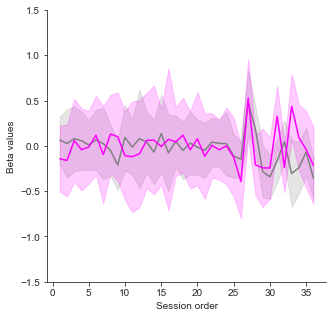

In [15]:
# Plot the line plot of the session index
# set style to ticks to match matlab figures
sns.set_style("ticks")
fig, cur_ax = plt.subplots(1,1,figsize=[5, 5])
cur_ax = sns.lineplot(x='session_index', 
            y='rinse_Betas_mean',
            data=df_beta_new, 
            ax=cur_ax,
            color='gray',
            ci="sd")
cur_ax = sns.lineplot(x='session_index', 
            y='high_low_betas_mean',
            data=df_beta_new, 
            ax=cur_ax,
            color='magenta',
            ci="sd")
cur_ax.set_xlabel('Session order')
cur_ax.set_ylabel('Beta values')
cur_ax.get_xaxis().set_visible(True)
cur_ax.set_ylim([-1.5,1.5])
sns.despine()

plt.show()
fig_name = os.path.join(get_fig_dir(), 'session_index_lineplots.svg')
fig.savefig(fig_name)

In [16]:
# Create a stacked variable for the rinse vs tastant betas for animal boxplots and the Taste Quality plots below
rinse_vs_taste = df_beta_new.rename(columns={"high_low_betas_mean": "Tastant",
"rinse_Betas_mean": "Rinse"}).melt(id_vars = ['session_index', 'animal_index','date_tag','taste', 'region_name', 'hemisphere'], 
                                  value_vars=['Rinse','Tastant'],
                                  var_name = 'solution',
                                  value_name='beta')
rinse_vs_taste

rinse_vs_high_vs_low = df_beta_new.rename(columns={"high_Betas_mean": "High", "low_Betas_mean": "Low", "rinse_Betas_mean": "Rinse"}).melt(
                                  id_vars = ['session_index', 'animal_index','date_tag','taste', 'region_name', 'hemisphere'], 
                                  value_vars = ['Rinse','High', 'Low'],
                                  var_name = 'solution',
                                  value_name = 'beta')

len(rinse_vs_high_vs_low.date_tag.unique())
rinse_vs_taste.head()


session_index animal_index date_tag taste      region_name hemisphere  \
0              1          B09   B09Gb1  sour       ACC_area24          L   
1              1          B09   B09Gb1  sour       ACC_area32          L   
2              1          B09   B09Gb1  sour  Idfm_custom_bin          L   
3              1          B09   B09Gb1  sour             Idys          L   
4              1          B09   B09Gb1  sour               Ig          L   

  solution      beta  
0    Rinse -0.093027  
1    Rinse -0.117917  
2    Rinse  0.037382  
3    Rinse -0.124586  
4    Rinse -0.037567

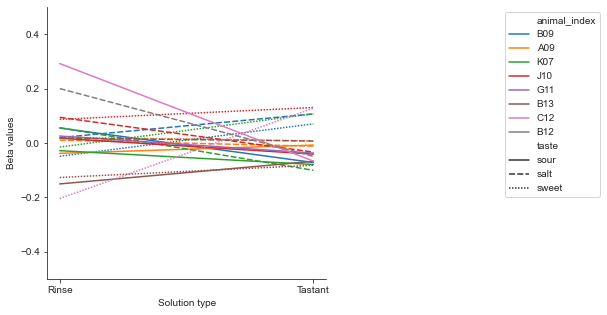

array([-0.06408129, -0.06470785,  0.06891722])

In [17]:
# Taste vs rinse average beta comparisons
fig, cur_ax = plt.subplots(1,1,figsize=[5, 5])
cur_ax = sns.lineplot(x='solution', 
            y='beta',
            style='taste',
            hue='animal_index',
            data=rinse_vs_taste, 
            ax=cur_ax,
            color='magenta',
            ci=None)

cur_ax.set_xlabel('Solution type')
cur_ax.set_ylabel('Beta values')
cur_ax.get_xaxis().set_visible(True)
cur_ax.set_ylim([-.5,.5])
sns.despine()
plt.legend(loc='upper right',bbox_to_anchor=(2,1))
plt.show()
fig_name = os.path.join(get_fig_dir(), 'session_index_lineplots.svg')
fig.savefig(fig_name)


Averages = rinse_vs_taste.groupby(['taste','solution']).mean()
# The change in the average betas between rinse and tastant solutions of each taste type
Averages.loc[(slice(None),'Tastant'),'beta'].values - Averages.loc[(slice(None),'Rinse'),'beta'].values

In [18]:
# Interquartile ranges for reporting
IQR_animals = rinse_vs_taste.groupby(['animal_index','solution']).quantile(.75) - rinse_vs_taste.groupby(['animal_index','solution']).quantile(.25)
display(IQR_animals)

IQR_solution = rinse_vs_high_vs_low.groupby(['solution']).quantile(0.75) - rinse_vs_high_vs_low.groupby(['solution']).quantile(0.25)

display(IQR_solution)

# The change in the IQR of betas between rinse and tastant solutions of each subject
IQR_animals.loc[(slice(None),'Tastant'),'beta'].values - IQR_animals.loc[(slice(None),'Rinse'),'beta'].values


session_index      beta
animal_index solution                         
A09          Rinse             13.00  0.237138
             Tastant           13.00  0.368156
B09          Rinse              8.00  0.274799
             Tastant            8.00  0.378245
B12          Rinse              2.00  0.452928
             Tastant            2.00  0.480696
B13          Rinse             16.25  0.438352
             Tastant           16.25  0.608539
C12          Rinse              5.50  0.726301
             Tastant            5.50  0.665904
G11          Rinse              4.00  0.302932
             Tastant            4.00  0.381575
J10          Rinse             11.00  0.496024
             Tastant           11.00  0.727982
K07          Rinse             13.00  0.348177
             Tastant           13.00  0.651988

session_index      beta
solution                         
High               12.0  0.591228
Low                12.0  0.619636
Rinse              12.0  0.353835

array([ 0.13101849,  0.10344562,  0.02776763,  0.17018681, -0.06039684,
        0.07864309,  0.23195806,  0.30381111])

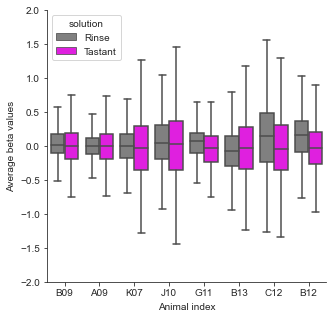

In [19]:
fig, cur_ax = plt.subplots(1,1,figsize=[5, 5])
cur_ax = sns.boxplot(x='animal_index', 
            y='beta' ,
            hue='solution',
            palette=['grey', 'magenta'],
            data=rinse_vs_taste, 
            ax=cur_ax,
            showfliers=False)

cur_ax.set_ylim([-2,2])
cur_ax.set_xlabel('Animal index')
cur_ax.set_ylabel('Average beta values')
# Remove the box
sns.despine()
plt.show()
fig_name = os.path.join(get_fig_dir(), 'animal_beta_boxplots.svg')
fig.savefig(fig_name)

In [20]:
# Read the partitions
partitions = pd.read_csv(os.path.join(get_local_datadir(), 'partition_paper.csv'), sep=';')

assert sorted(df_beta_new['varname_str'].unique()) == sorted(partitions.columns)
partitions

L_ACC_area24  L_ACC_area32  L_MCC  L_OFC  L_PFC  L_area13  \
0             0             0      0      0      0         0   

   L_posterior_medial_cortex_area7m  L_subgenual_area25  R_ACC_area24  \
0                                 0                   0             0   

   R_ACC_area32  R_MCC  R_OFC  R_PFC  R_area13  \
0             0      0      0      0         0   

   R_posterior_medial_cortex_area7m  R_subgenual_area25  L_Idfm_custom_bin  \
0                                 0                   0                  1   

   L_Idys  L_Ig  L_NAc  L_PrCo  L_Ri  L_S1  L_S2  L_agranularIns_bin  \
0       1     1      1       1     1     1     1                   1   

   L_amygdala  L_caudate  L_dAIC_custom_bin_agranTrim  L_paraIns  \
0           1          1                            1          1   

   L_parietal_lobule_area3b  L_putamen  R_Idfm_custom_bin  R_Idys  R_Ig  \
0                         1          1                  1       1     1   

   R_NAc  R_PrCo  R_Ri  R_S1  R_S2  R_agranularIns_bin  R_amygdala  R_caudate  \
0      1       1     1     1     1                   1           1          1   

   R_dAIC_custom_bin_agranTrim  R_paraIns  R_parietal_lobule_area3b  \
0                            1          1                         1   

   R_putamen  L_PAG  L_PBC  L_SN  L_globus_pallidus  L_hypothalamus  \
0          1      2      2     2                  2               2   

   L_thalamus_ohne_genicula  R_PAG  R_PBC  R_SN  R_globus_pallidus  \
0                         2      2      2     2                  2   

   R_hypothalamus  R_thalamus_ohne_genicula  
0               2                         2

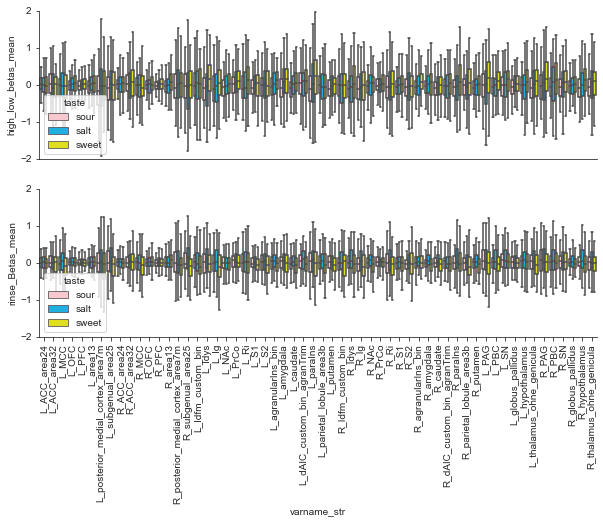

In [21]:
# Visualize 
fig, (ax_tastant, ax_rinse) = plt.subplots(2, 1, figsize=[10, 6])
sns.boxplot(x='varname_str',
            y='rinse_Betas_mean', 
            hue="taste",
            palette=['pink','deepskyblue','yellow'],
            order=partitions.columns,
            data=df_beta_new, 
            ax=ax_rinse,
            showfliers=False)
ax_tastant.tick_params(axis='x', rotation=90)
ax_tastant.get_xaxis().set_visible(False)
ax_tastant.set_ylim([-2,2])
sns.boxplot(x='varname_str',
            y='high_low_betas_mean',
            palette=['pink','deepskyblue','yellow'],
            hue="taste", 
            order=partitions.columns,
            data=df_beta_new, 
            ax=ax_tastant,
            showfliers=False)
ax_rinse.tick_params(axis='x', rotation=90)
ax_rinse.set_ylim([-2,2])
sns.despine()
plt.show()
fig_name = os.path.join(get_fig_dir(), 'taste_by_region.svg')
fig.savefig(fig_name)


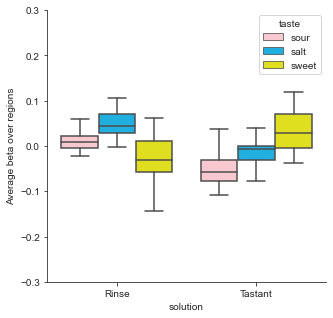

In [22]:
# Average over regions for both rinse and taste betas and box plot
fig, ax = plt.subplots(figsize=[5, 5])
vars_interest = ['taste', 'region_name', 'high_low_betas_mean', 'rinse_Betas_mean']
means = df_beta_new.groupby(by=['region_name', 'taste'],sort=False).mean().reset_index()
means = means[vars_interest]
rinse_means = means.iloc[:,[0,1,3]].rename(columns={'rinse_Betas_mean':'Average beta over regions'}).assign(solution='Rinse')
taste_means = means.iloc[:,[0,1,2]].rename(columns={'high_low_betas_mean':'Average beta over regions'}).assign(solution='Tastant')

forplot = pd.concat([rinse_means,taste_means],axis=0)
sns.boxplot(data=forplot,
            x='solution', 
            hue='taste',
            y='Average beta over regions', 
            palette=['pink','deepskyblue','yellow'],
            showfliers=False)
sns.despine()
fig_name = os.path.join(get_fig_dir(), 'violin_Taste_vs_rinse_average_region_beta.svg')
plt.ylim([-0.3, 0.3])
fig.savefig(fig_name)

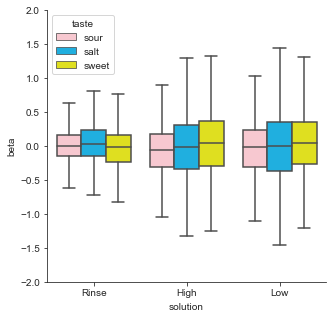

In [23]:
# Plot beta values separated by rinse and tastant not averaged over regions
fig, ax = plt.subplots(figsize=[5, 5])
sns.boxplot(data=rinse_vs_high_vs_low,
            x='solution', 
            hue='taste',
            y='beta', 
            palette=['pink','deepskyblue','yellow'],
            #palette=['red', 'cyan'],
            showfliers=False,
            order=['Rinse', 'High', 'Low'])
fig_name = os.path.join(get_fig_dir(), 'Taste_vs_rinse_by_tastant.svg')
sns.despine()
plt.ylim([-2, 2])
fig.savefig(fig_name)


In [24]:
# Test for the difference in beta values of tastant vs rinse
from scipy.stats import ttest_ind

gb = rinse_vs_taste.groupby(['taste', 'solution'])
gb = dict(list(gb))

taste_str = ['sour', 'salt', 'sweet']
test_results = []
for t in taste_str:
    cur_taste_idx = [key for key in gb.keys() if key[0] == t]
    idx_rinse, idx_taste = cur_taste_idx
    test_results.append(ttest_ind(gb[idx_rinse]['beta'], gb[idx_taste]['beta']))
print('Ttest comparison of tastant vs rinse run averaged betas:')
display(pd.DataFrame(test_results, index=taste_str))

Ttest comparison of tastant vs rinse run averaged betas:


statistic        pvalue
sour   10.098229  6.998611e-24
salt    7.245433  4.615646e-13
sweet  -7.235058  5.013173e-13

In [25]:

cur_taste_idx

[('sweet', 'Rinse'), ('sweet', 'Tastant')]

In [32]:
gb[idx_low]['beta']

43244    0.348804
43245    0.147289
43246    0.462532
43247    0.115039
43248    0.198118
           ...   
47995    0.059459
47996   -0.124301
47997   -0.146249
47998   -0.980966
47999   -0.715698
Name: beta, Length: 4756, dtype: float64

In [26]:
# Test for differences between high and low concentrations as well
gb = rinse_vs_high_vs_low.groupby(['taste', 'solution'])
gb = dict(list(gb))

taste_str = ['sour', 'salt', 'sweet']
test_results = []
for t in taste_str:
    cur_taste_idx = [key for key in gb.keys() if key[0] == t]
    idx_high, idx_low, idx_rinse = cur_taste_idx
    test_results.append(ttest_ind(gb[idx_high]['beta'], gb[idx_low]['beta']))
print('Ttest comparison of High vs Low run averaged betas:')
display(pd.DataFrame(test_results, index=taste_str))

Ttest comparison of High vs Low run averaged betas:


statistic    pvalue
sour   -2.669957  0.007596
salt   -0.482713  0.629309
sweet   0.059659  0.952428

In [27]:
# The name of categorical and numerical independant variable columns
indep_colnames = {'cat': ['taste', 'animal_index', 'date_tag', 'hemisphere', 'region_name','solution'], 'num': ['session_index']}
rinse_vs_high_vs_low, indep_colnames_withrand = add_permutated(df=rinse_vs_high_vs_low, indep_colnames=indep_colnames)
df_split = prepare_data_splits(df_beta=rinse_vs_high_vs_low, indep_colnames=indep_colnames, dep_varnames=['beta'])

In [28]:
# Split Y and X: X_train, X_test, y_train, y_test
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

reg_constructor = RandomForestRegressor
input_dict = {"n_estimators": 100, "n_jobs": -1, "oob_score": True, "bootstrap": True,"random_state": 42}
#reg_constructor = LinearRegression
#input_dict = {}

reg_results = []
# Loop over rows with different beta values
for _,cur_data in df_split.iterrows():
    # Define current pipeline to fit the row of data splits
    cur_pipe_reg = define_reg_pipeline(reg_estimator=reg_constructor, 
                                       input_dict=input_dict,
                                       indep_colnames=indep_colnames)
    # Apply the regression
    cur_reg_results = apply_regression(data_tbl=cur_data, model=cur_pipe_reg)
    reg_results.append(cur_reg_results)

reg_results = pd.concat(reg_results)
# See r_squared
display(reg_results)

KeyboardInterrupt: 

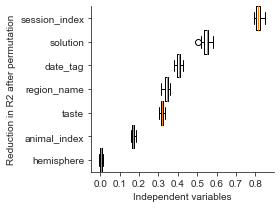

In [ ]:
# Plot the permutation importance for the different dependant variables
indep_all = np.asarray(sum(indep_colnames.values(),[]))

for _, cur_row in reg_results.iterrows():   
    result = cur_row.perm_importance
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots(figsize=[4,3])
    ax.boxplot(result.importances[sorted_idx].T,
            vert=False,widths=1, labels=indep_all[sorted_idx])
    ax.set_xlabel("Independent variables")
    ax.set_ylabel(f"Reduction in R2 after permutation")
    ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
    ax.tick_params(axis='x', rotation=0)
    fig.tight_layout()
    sns.despine()
    plt.show()
    fig_name = os.path.join(get_fig_dir(), 'permutation_random_Forest_R^2_0.4299.svg')
    fig.savefig(fig_name)

# Note on the reason why the R2 reduction is larger than the total R2 for the top 2 variables
# The reason is that the permuting the top 2 variables makes the R2 of the model negative

In [ ]:
# Display mean importances
mean_importance = pd.DataFrame(result.importances_mean[sorted_idx].round(3) * 100).T
mean_importance.columns = indep_all[sorted_idx]
display(mean_importance)

hemisphere  animal_index  taste  region_name  date_tag  solution  \
0         0.6          17.0   31.8         34.1      40.4      54.6   

   session_index  
0           81.6

In [ ]:
df_beta_new.head()

taste  session_index  old_session_index animal_index date_tag hemisphere  \
0  sour              1                 11          B09   B09Gb1          L   
1  sour              1                 11          B09   B09Gb1          L   
2  sour              1                 11          B09   B09Gb1          L   
3  sour              1                 11          B09   B09Gb1          L   
4  sour              1                 11          B09   B09Gb1          L   

       region_name     identifier_str        varname_str  all_Betas_mean  \
0       ACC_area24       L-ACC-area24       L_ACC_area24       -9.309388   
1       ACC_area32       L-ACC-area32       L_ACC_area32       -6.874276   
2  Idfm_custom_bin  L-Idfm-custom-bin  L_Idfm_custom_bin      -12.561705   
3             Idys             L-Idys             L_Idys      -10.307085   
4               Ig               L-Ig               L_Ig      -25.518260   

   high_low_betas_mean  high_Betas_mean  low_Betas_mean  rinse_Betas_mean  
0            -0.251904        -0.245013       -0.257934         -0.093027  
1             0.076101         0.144005        0.016685         -0.117917  
2             0.023288        -0.048488        0.086093          0.037382  
3            -0.308063        -0.014974       -0.564515         -0.124586  
4            -0.464616        -0.363997       -0.552658         -0.037567

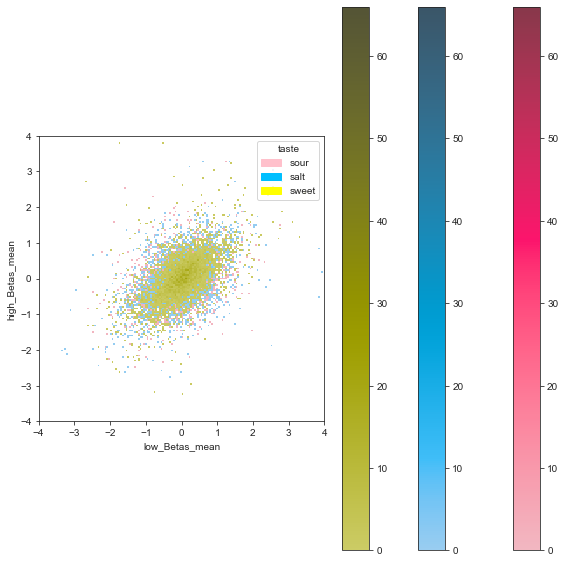

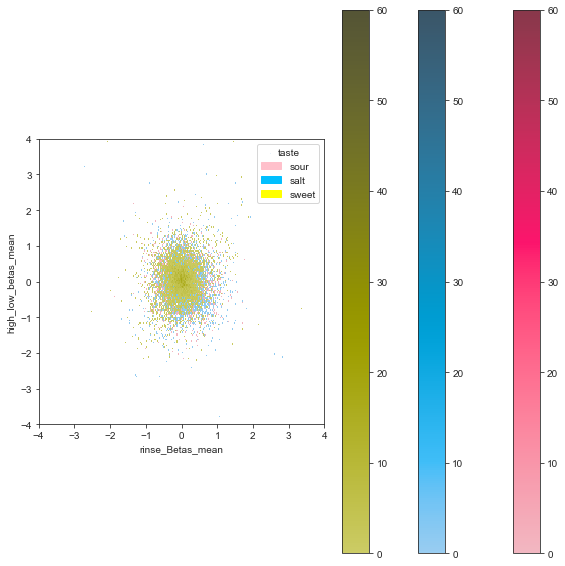

In [ ]:
# Plot correlation between the rinse and the tastant betas
fig, ax = plt.subplots(figsize=[10, 10])
sns.histplot(x='low_Betas_mean',
            y='high_Betas_mean',
            hue='taste',
            palette=['pink','deepskyblue','yellow'],
            data=df_beta_new,
            ax=ax,
            cbar=True)
plt.axis('scaled')
plt.xlim([-4,4])
plt.ylim([-4,4])


fig_name = os.path.join(get_fig_dir(), 'corr_histogram_high_vs_low.svg')
fig.savefig(fig_name)

fig, ax = plt.subplots(figsize=[10, 10])
sns.histplot(x='rinse_Betas_mean',
            y='high_low_betas_mean',
            hue='taste',
            palette=['pink','deepskyblue','yellow'],
            data=df_beta_new,
            ax=ax,
            cbar=True)
plt.axis('scaled')
plt.xlim([-4,4])
plt.ylim([-4,4])


fig_name = os.path.join(get_fig_dir(), 'corr_histogram_taste_vs_rinse.svg')
fig.savefig(fig_name)
